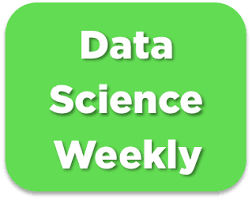

# Challenge : predict conversions

# Importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, confusion_matrix

import plotly.graph_objects as go

# Reading file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Exploring dataset
See file *0_Conversion_rate_challenge_EDA.ipynb*

# Making the your model

In [4]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

In [5]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [6]:
# Dividing dataset into Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [7]:
numeric_features = ['age', 'total_pages_visited'] # Names of numeric columns in X_train/X_test

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # standardization
])

In [8]:
categorical_features = ['country', 'new_user', 'source'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [9]:
# Using ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5, :])
print()

Performing preprocessings on train set...
...Done.
[[-1.3990984  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.29299544  0.03743241  0.          0.          1.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  0.          0.          1.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  0.          0.          0.          1.
   0.          1.        ]]



In [11]:
# Performing grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    #'base_estimator__max_depth': [1, 2, 3], parameters used for iteration 1
    #'base_estimator__max_depth': [6, 9, 12], iteration 2
    'base_estimator__max_depth': [6],
    #'base_estimator__min_samples_leaf': [1, 2, 3], parameters used for iteration 1
    'base_estimator__min_samples_leaf': [1],
    #'base_estimator__min_samples_split': [2, 3, 4], parameters used for iteration 1
    'base_estimator__min_samples_split': [2],
    #'n_estimators': [2, 4, 6, 8, 10] parameters used for iteration 1
    # 'n_estimators': [12, 20, 40]
    'n_estimators': [12]
}
print(params)
best_ada_tree = GridSearchCV(model, param_grid = params, cv = 5, scoring = "f1") 
# cv : the number of folds to be used for CV
best_ada_tree.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", best_ada_tree.best_params_)
print("Best f1 score : ", best_ada_tree.best_score_)


Grid search...
{'base_estimator__max_depth': [6], 'base_estimator__min_samples_leaf': [1], 'base_estimator__min_samples_split': [2], 'n_estimators': [12]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 6, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 12}
Best f1 score :  0.7590592482900342


In [12]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_ada_tree.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [13]:
print("Performing preprocessings on test set...")

print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:]) 
print()


Performing preprocessings on test set...
Encoding categorical features and standardizing numerical features...
...Done.
[[ 0.41385929 -1.15935344  0.          1.          0.          1.
   0.          0.        ]
 [ 0.1721316   0.03743241  0.          1.          0.          0.
   0.          0.        ]
 [ 1.62249775 -1.15935344  0.          0.          1.          1.
   0.          0.        ]
 [ 0.53472314 -1.15935344  0.          0.          1.          1.
   1.          0.        ]
 [-0.19045994 -0.56096051  0.          0.          1.          1.
   1.          0.        ]]



In [14]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_ada_tree.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [15]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.769867549668874
f1-score on test set :  0.7450390859891762


In [16]:
# Using a simple confusion matrix to understand what the model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219491    829]
 [  2229   5115]]

Confusion matrix on test set : 
[[54829   251]
 [  597  1239]]



# Training the model on all data and using it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [17]:
# Concatenating our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_ada_tree.fit(X,Y)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [6],
                         'base_estimator__min_samples_leaf': [1],
                         'base_estimator__min_samples_split': [2],
                         'n_estimators': [12]},
             scoring='f1')

In [18]:
# Reading data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Checking consistency of thr features_list
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [19]:
# Making the same preprocessings as for the Test set
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31132378  3.3285935   0.          1.          0.          0.
   0.          1.        ]
 [-1.03650686  0.03743241  0.          1.          0.          1.
   1.          0.        ]
 [ 0.1721316  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.1721316   0.33662888  0.          0.          1.          1.
   0.          0.        ]
 [-0.67391532 -0.56096051  0.          0.          0.          0.
   0.          1.        ]]


In [20]:
# Making predictions and dumping to file
data = {
    'converted': best_ada_tree.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_YULIYA-model2.csv', index=False)


## Analyzing the coefficients and interpreting the result


In [21]:
# Getting feature names corresponding to each coefficient:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['age', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'new_user_1', 'source_Direct', 'source_Seo']


In [22]:
# Getting feature importance as an array
feature_importance = best_ada_tree.best_estimator_.feature_importances_
print(feature_importance)

# Converting to list
feature_importance = feature_importance.tolist()

feature_importance_df = pd.DataFrame(list(zip(column_names, feature_importance)), 
                                     columns = ['feature', 'adaboost_feature_importance'])

feature_importance_df = feature_importance_df.sort_values(by='adaboost_feature_importance', ascending=False)

feature_importance_df

[0.33713493 0.33954542 0.03911171 0.0564143  0.03877886 0.07844873
 0.04637455 0.0641915 ]


,feature,adaboost_feature_importance
1,total_pages_visited,0.339545
0,age,0.337135
5,new_user_1,0.078449
7,source_Seo,0.064191
3,country_UK,0.056414
6,source_Direct,0.046375
2,country_Germany,0.039112
4,country_US,0.038779


In [23]:
fig = go.Figure(go.Bar(x = feature_importance_df['adaboost_feature_importance'],
                       y = feature_importance_df['feature'], 
                       orientation='h'))

fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

In [25]:
# Saving data on feature importance for future use
feature_importance_df.to_csv("adaboost_feature_importance.csv", index=False)